In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import string
import re
import matplotlib.pyplot as plt
import math
from matplotlib import rc
#from google.colab import drive
from sklearn.model_selection import train_test_split
from collections import Counter, defaultdict
from sklearn.metrics import accuracy_score
import matplotlib.ticker as ticker
from math import sqrt


from sklearn.metrics import mean_squared_error

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.3)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)

In [3]:
#plays
ratings = pd.read_csv(r'ratings.csv')
#artists 
movies= pd.read_csv(r'movies.csv')

ap = pd.merge(
  movies, ratings, 
  how="inner",
  left_on="movieid",
  right_on="movieid"
)

In [4]:
ap = pd.merge(
  ratings, movies, 
  how="inner",
  left_on="movieId",
  right_on="movieId"
)

In [5]:
ap.head()

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,5,1,4.0,847434962,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7,1,4.5,1106635946,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,15,1,2.5,1510577970,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,17,1,4.5,1305696483,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


In [6]:
movie_rank = ap.groupby(['title']) \
  .agg({'userId' : 'count', 'rating' : 'sum'}) \
  .rename(columns={"userId" : 'total_Unique_Users', "rating" : "total_ratings"}) \
  .sort_values(['total_ratings'], ascending=False)

movie_rank['avg_User_ratings'] = movie_rank['total_ratings'] / movie_rank['total_Unique_Users']

In [7]:
movie_rank

,total_Unique_Users,total_ratings,avg_User_ratings
title,,,
"Shawshank Redemption, The (1994)",317,1404.0,4.429022
Forrest Gump (1994),329,1370.0,4.164134
Pulp Fiction (1994),307,1288.5,4.197068
"Matrix, The (1999)",278,1165.5,4.192446
"Silence of the Lambs, The (1991)",279,1161.0,4.161290
...,...,...,...
Uncle Nino (2003),1,0.5,0.500000
Legionnaire (1998),1,0.5,0.500000
Ring of Terror (1962),1,0.5,0.500000


In [8]:
ap = ap.join(movie_rank, on="title", how="inner") \
  .sort_values(['rating'], ascending=False)

In [9]:
ap

,userId,movieId,rating,timestamp,title,genres,total_Unique_Users,total_ratings,avg_User_ratings
26165,56,364,5.0,835799253,"Lion King, The (1994)",Adventure|Animation|Children|Drama|Musical|IMAX,172,678.0,3.941860
9175,494,1291,5.0,1001666641,Indiana Jones and the Last Crusade (1989),Action|Adventure,140,566.5,4.046429
24565,246,4226,5.0,1353869474,Memento (2000),Mystery|Thriller,159,655.5,4.122642
9179,524,1291,5.0,851609392,Indiana Jones and the Last Crusade (1989),Action|Adventure,140,566.5,4.046429
49182,469,1230,5.0,965336139,Annie Hall (1977),Comedy|Romance,58,224.5,3.870690
...,...,...,...,...,...,...,...,...,...
51236,22,68358,0.5,1268727244,Star Trek (2009),Action|Adventure|Sci-Fi|IMAX,59,228.0,3.864407
85588,160,4887,0.5,1065992285,"One, The (2001)",Action|Sci-Fi|Thriller,14,38.5,2.750000
85589,219,4887,0.5,1195944988,"One, The (2001)",Action|Sci-Fi|Thriller,14,38.5,2.750000
96027,599,5428,0.5,1498502739,Cheech & Chong's The Corsican Brothers (1984),Comedy,4,4.5,1.125000


In [10]:
def bar_chart_int(x,y,x_label,y_label,title,caption,total_val):
    fig, ax = plt.subplots()
    fig.set_size_inches(16, 5)
    ax = sns.barplot(x[:20], y[:20], palette='Blues_r')
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(title)
    ax.get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: '{:,}'.format(int(x))))

    # our bar label placement
    for p in ax.patches:
        height = p.get_height()
        pct = 100*(height/total_val)
        ax.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.1f}%'.format(pct),
                ha="center",verticalalignment='bottom',color='black', fontsize=12) 

    # our caption statement
    ax.text(19, max(y[:20])*0.95, caption,horizontalalignment='right')

    plt.xticks(rotation=90)
    plt.show()

In [11]:
pc = ap.rating
rating_scaled = (pc - pc.min()) / (pc.max() - pc.min())

ap = ap.assign(ratingScaled=rating_scaled)

In [12]:
ratings_df = ap.pivot(
    index='userId', 
    columns='movieId', 
    values='ratingScaled'
)

In [13]:
ratings = ratings_df.fillna(0).values

In [14]:
sparsity = float(len(ratings.nonzero()[0]))
sparsity /= (ratings.shape[0] * ratings.shape[1])
sparsity *= 100
print('{:.2f}%'.format(sparsity))

1.68%


In [15]:
train, val = train_test_split(ratings,test_size=0.1)

In [16]:
train.shape,val.shape

((549, 9724), (61, 9724))

In [17]:
def rmse(prediction, ground_truth):
    prediction = prediction[ground_truth.nonzero()].flatten() 
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()
    return sqrt(mean_squared_error(prediction, ground_truth))

In [18]:
class Recommender:
  
  def __init__(self, n_epochs=200, n_latent_features=3, lmbda=0.5, learning_rate=0.001):
    self.n_epochs = n_epochs
    self.n_latent_features = n_latent_features
    self.lmbda = lmbda
    self.learning_rate = learning_rate
  
  def predictions(self, P, Q):
    return np.dot(P.T, Q)
  
  def fit(self, X_train, X_val):
    m, n = X_train.shape

    self.P = 3 * np.random.rand(self.n_latent_features, m)
    self.Q = 3 * np.random.rand(self.n_latent_features, n)
    
    self.train_error = []
    self.val_error = []

    users, items = X_train.nonzero()
    
    for epoch in range(self.n_epochs):
        for u, i in zip(users, items):
            error = X_train[u, i] - self.predictions(self.P[:,u], self.Q[:,i])
            self.P[:, u] += self.learning_rate * (error * self.Q[:, i] - self.lmbda * self.P[:, u])
            self.Q[:, i] += self.learning_rate * (error * self.P[:, u] - self.lmbda * self.Q[:, i])

        train_rmse = rmse(self.predictions(self.P, self.Q), X_train)
        val_rmse = rmse(self.predictions(self.P, self.Q), X_val)
        self.train_error.append(train_rmse)
        self.val_error.append(val_rmse)
        
    return self
  
  def predict(self, X_train, user_index):
    y_hat = self.predictions(self.P, self.Q)
    predictions_index = np.where(X_train[user_index, :] == 0)[0]
    return y_hat[user_index, predictions_index].flatten()

In [ ]:
recommender = Recommender().fit(train, val)

In [ ]:
plt.plot(range(recommender.n_epochs), recommender.train_error, marker='o', label='Training Data');
plt.plot(range(recommender.n_epochs), recommender.val_error, marker='v', label='Validation Data');
plt.xlabel('Number of Epochs');
plt.ylabel('RMSE');
plt.title('Training and Validation accuracy')
plt.legend()
plt.grid()
plt.show()

In [19]:
user_id = 153
user_index = ratings_df.index.get_loc(user_id)
predictions_index = np.where(train[user_index, :] == 0)[0]

rating_predictions = recommender.predict(train, user_index)

NameError: name 'recommender' is not defined

In [ ]:
def create_movie_ratings(movie_df, artists_index, ratings, n=10):
  artist_ids = ratings_df.columns[artists_index]
  artist_ratings = pd.DataFrame(data=dict(movieId=artist_ids, rating=ratings))
  top_n_artists = artist_ratings.sort_values("rating", ascending=False).head(n)
  
  artist_recommendations = movie_df[movie_df.movieId.isin(top_n_artists.movieId)].reset_index(drop=True)
  artist_recommendations['rating'] = pd.Series(top_n_artists.rating.values)
  return artist_recommendations.sort_values("rating", ascending=False)

In [ ]:
existing_ratings_index = np.where(train[user_index, :] > 0)[0]
existing_ratings = train[user_index, existing_ratings_index]

create_movie_ratings(movies, existing_ratings_index, existing_ratings)

In [ ]:
create_movie_ratings(movies, predictions_index, rating_predictions)

lambda: 0.5


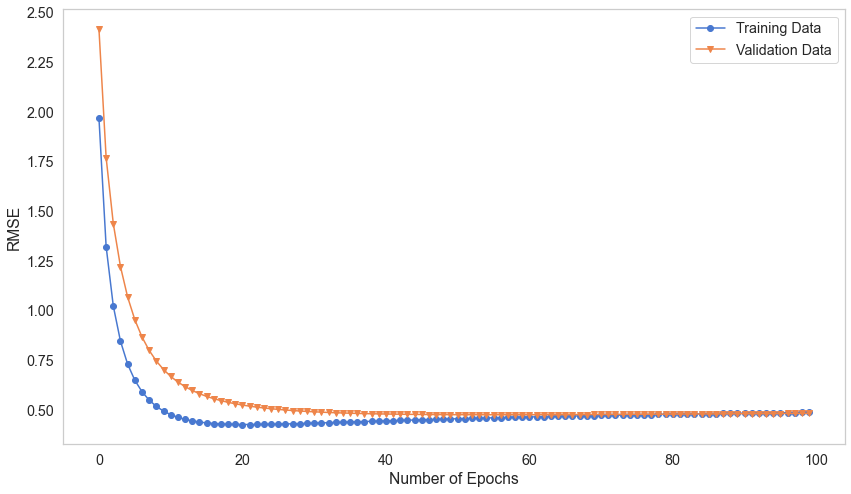

lambda: 2.0


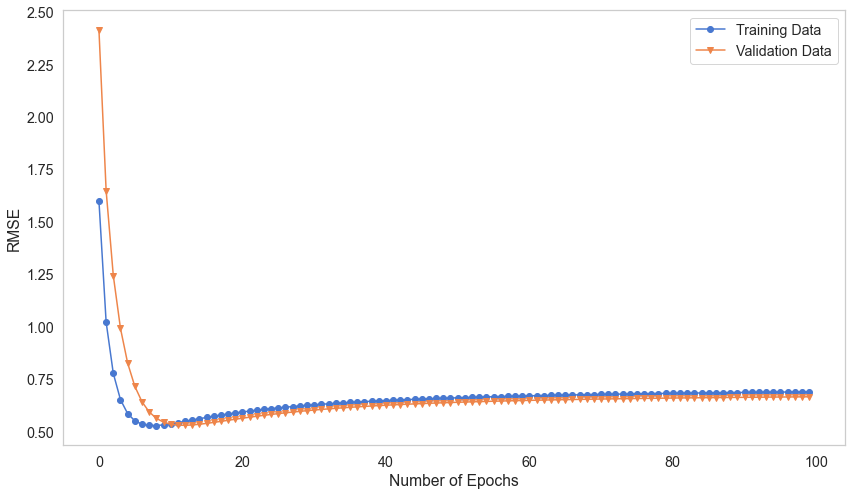

lambda: 5.0


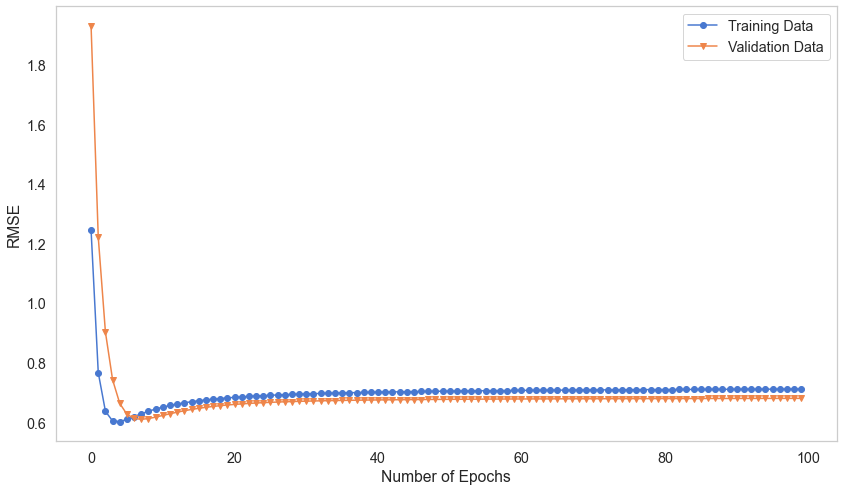

lambda: 10.0


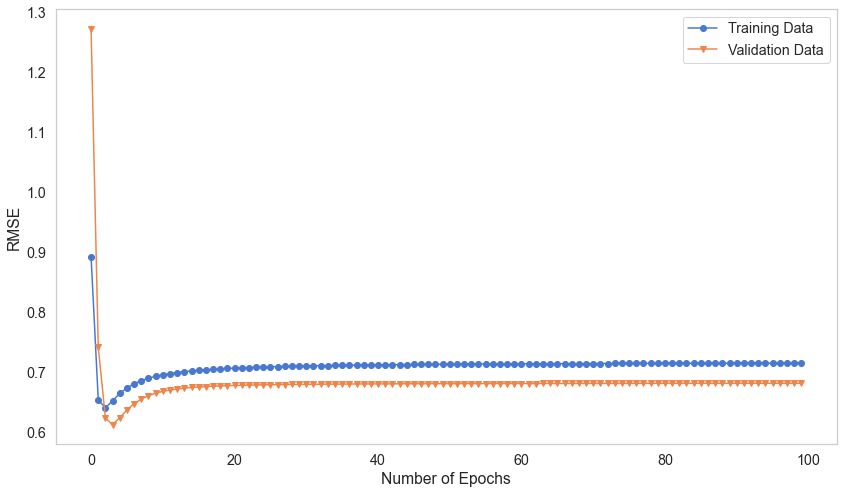

lambda: 20.0


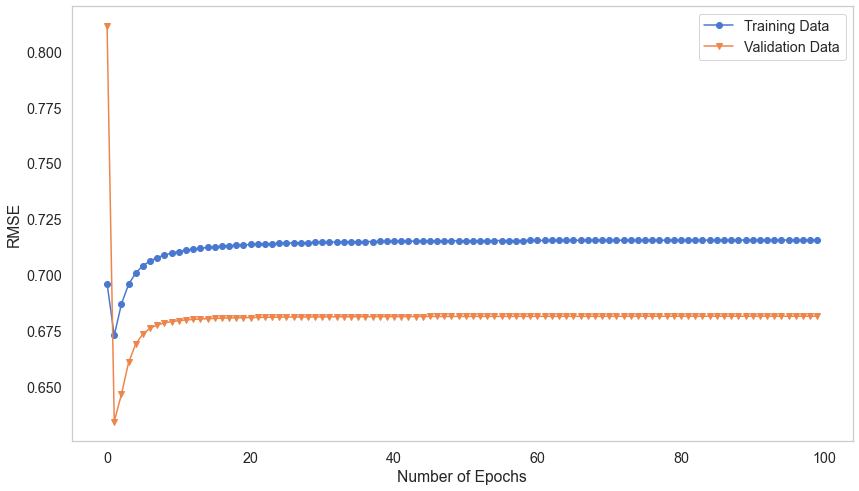

In [ ]:
for l in [0.5,2,5,10,20,50,100,500,1000]:    
    class Recommender:

      def __init__(self, n_epochs=100, n_latent_features=3, lmbda=l, learning_rate=0.001):
        self.n_epochs = n_epochs
        self.n_latent_features = n_latent_features
        self.lmbda = lmbda
        self.learning_rate = learning_rate

      def predictions(self, P, Q):
        return np.dot(P.T, Q)

      def fit(self, X_train, X_val):
        m, n = X_train.shape

        self.P = 3 * np.random.rand(self.n_latent_features, m)
        self.Q = 3 * np.random.rand(self.n_latent_features, n)

        self.train_error = []
        self.val_error = []

        users, items = X_train.nonzero()

        for epoch in range(self.n_epochs):
            for u, i in zip(users, items):
                error = X_train[u, i] - self.predictions(self.P[:,u], self.Q[:,i])
                self.P[:, u] += self.learning_rate * (error * self.Q[:, i] - self.lmbda * self.P[:, u])
                self.Q[:, i] += self.learning_rate * (error * self.P[:, u] - self.lmbda * self.Q[:, i])

            train_rmse = rmse(self.predictions(self.P, self.Q), X_train)
            val_rmse = rmse(self.predictions(self.P, self.Q), X_val)
            self.train_error.append(train_rmse)
            self.val_error.append(val_rmse)

        return self

      def predict(self, X_train, user_index):
        y_hat = self.predictions(self.P, self.Q)
        predictions_index = np.where(X_train[user_index, :] == 0)[0]
        return y_hat[user_index, predictions_index].flatten()

    recommender = Recommender().fit(train, val)
    print('lambda:',float(l))
    plt.plot(range(recommender.n_epochs), recommender.train_error, marker='o', label='Training Data');
    plt.plot(range(recommender.n_epochs), recommender.val_error, marker='v', label='Validation Data');
    plt.xlabel('Number of Epochs');
    plt.ylabel('RMSE');
    plt.legend()
    plt.grid()
    plt.show()